#### Project: LeNet-5 classic network digit classifiers with MNIST datasets
Here I redesign the LeNet-5 architecture by replacing the pooling layers wiht Maxpooling and the hidden layers with relu instead of tanh and the output layers with softmax layers instead.

#### Packages selection
- The first things is to import all the neccesary packages needed for this project

In [3]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image

# select GPU if cuda is available
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

#### Settings
- Configure the device
- define all the hyperparameters to be used and needed to be tuned to achive a better accuracy
- Load and explore the data

In [4]:
# device
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# model architecture parameters
NUM_FEATURES = 32*32
NUM_CLASSES = 10


# others
GRAYSCALE = True

# rescale the data from 28*28 to 32*32
resize_transform = transforms.Compose([transforms.Resize((32, 32)),
                                      transforms.ToTensor()])


# dataset -> MNIST
# Note: transforms.ToTesnsor() scale the image from range 0-1

train_dataset = datasets.MNIST(root='data',
                              train=True,
                              transform=resize_transform,
                              download=True)

test_dataset = datasets.MNIST(root='data',
                             train=False,
                             transform=resize_transform)

train_loader = DataLoader(dataset=train_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

# check the dataset
for images,labels in train_loader:
    print("Image batch dimension", images.shape)
    print("Image Labels dimension", labels.shape)
    break

Image batch dimension torch.Size([128, 1, 32, 32])
Image Labels dimension torch.Size([128])


#### Define the architecture of the model such as
- The number of input layers; which is determined by the features of the data
- Number of total hidden layers in the model consist of only Convolution layers
- The output layer node units is determined by the intended outcome to achieve
- Here we have two layers convolutional neural networks

In [5]:
"""
Architecture: LeNet-5 == 5 Layers architecture and Conv layer + MaxPooling == 1 layer
X -> Conv2d -> ReLU -> MaxPool -> Conv2d -> ReLU -> MaxPool -> Linear -> ReLU -> Linear -> ReLu -> Linear -> Softmax -> y
"""

class LeNet5(nn.Module):
    def __init__(self, NUM_CLASSES, grayscale=False):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        
        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3
            
        self.features = nn.Sequential(
            
            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, NUM_CLASSES),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        outputs = self.classifier(x)
        probas = F.softmax(outputs, dim=1)
        return outputs, probas

#### Loss function and optimizer
- Instantiate the model
- define the specific Loss function to be used either cross entropy, MSELoss, etc
- define the optimization algorithm to be used either SGD, Adam, RMSprop, Momentum etc.

In [6]:
torch.manual_seed(RANDOM_SEED)
model = LeNet5(NUM_CLASSES, GRAYSCALE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#### compute accuracy
- A function to compute train and test accuracy

In [7]:
def compute_accuracy(model, data_loader):
    correct_predictions, num_examples = 0, 0
    for features, labels in data_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += labels.size(0)
        correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / num_examples * 100

#### Training a model requires the following steps
- Reset all the gradients to zero (0)
- Make a forward pass (make a prediction)
- Calculate the loss
- Perform back propagation
- Update all the parameters (weight and biases)

In [8]:
start_time = time.time()
total_step = len(train_loader)
for epoch in range(NUM_EPOCHS):
    for i, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)
        
        # forward and back pass
        output, probas = model(features)
        loss = F.cross_entropy(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Logging
        if not i % 50:
            print('Epoch: %03d/%03d | Batch: %03d/%03d | Cost:%.4f'
                 %(epoch+1, NUM_EPOCHS, i, total_step, loss))
    model.eval()
    print('Epoch: %03d/%03d training accuracy: %.2f%%' %(
    epoch+1, NUM_EPOCHS, compute_accuracy(model, train_loader)))
    print('Time Elapsed: %.2f min' %((time.time() - start_time) / 60))
print('Total Training Time: %.2f min' %((time.time() - start_time) / 60))

Epoch: 001/010 | Batch: 000/469 | Cost:2.3012
Epoch: 001/010 | Batch: 050/469 | Cost:0.5588
Epoch: 001/010 | Batch: 100/469 | Cost:0.4285
Epoch: 001/010 | Batch: 150/469 | Cost:0.3741
Epoch: 001/010 | Batch: 200/469 | Cost:0.2576
Epoch: 001/010 | Batch: 250/469 | Cost:0.1507
Epoch: 001/010 | Batch: 300/469 | Cost:0.1310
Epoch: 001/010 | Batch: 350/469 | Cost:0.2786
Epoch: 001/010 | Batch: 400/469 | Cost:0.0713
Epoch: 001/010 | Batch: 450/469 | Cost:0.1760
Epoch: 001/010 training accuracy: 96.35%
Time Elapsed: 0.26 min
Epoch: 002/010 | Batch: 000/469 | Cost:0.1220
Epoch: 002/010 | Batch: 050/469 | Cost:0.0898
Epoch: 002/010 | Batch: 100/469 | Cost:0.0559
Epoch: 002/010 | Batch: 150/469 | Cost:0.0237
Epoch: 002/010 | Batch: 200/469 | Cost:0.1449
Epoch: 002/010 | Batch: 250/469 | Cost:0.0807
Epoch: 002/010 | Batch: 300/469 | Cost:0.1181
Epoch: 002/010 | Batch: 350/469 | Cost:0.1166
Epoch: 002/010 | Batch: 400/469 | Cost:0.0537
Epoch: 002/010 | Batch: 450/469 | Cost:0.1589
Epoch: 002/010 t

#### Evaluation

In [50]:
with torch.set_grad_enabled(False): # save memory during Inference
    print('Test Accuracy: %.2f%%' %(compute_accuracy(model, test_loader)))

Test Accuracy: 98.81%


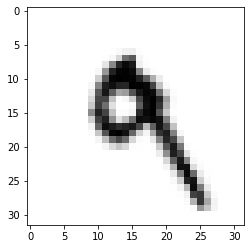

In [57]:
for i, (features, labels) in enumerate(test_loader):
    
    features = features
    labels = labels
    break
    
nhwc_img = np.transpose(features[7], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap="Greys");